# **An Investigation of Recycling Point Distribution and Accessibility in the Wards of Leeds**

Student number: 201802459

Markdown word count: 1434           

**Introduction**


An increasing public awareness of anthropogenic climate change has placed renewed importance on waste disposal (Kassim, 2012, p.43). Recycling infrastructure provides a means through which particular rubbish types can be collected and transformed into new products, as opposed to sitting in landfill (Lamma, 2021, p.298). In Leeds, small recycling sites known as “bring sites”, usually located in supermarkets and carparks, enable people to recycle used paper, glass, and clothing (Data Mill North, 2024). This project has aimed to provide insights on the accessibility and distribution of recycling facilities, plotting their location against the total population of the wards in which they sit. It is hoped that the visualisations produced throughout will highlight bring sites which are currently overburdened or inaccessible, and inform their future placement. This study has been conducted with open data sources to assist in the reproducibility of the findings, and has followed good data processing principles to uphold the transparency of the analysis.

Provided is the code and datasets needed to reproduce this study. It should be noted that some of the files (especially eng_wards) are particularly large and require some time to fully load into the notebook. The code is commented, and the visualisation choices are justified at the end of each section.



**Data Sources and Accreditation** (Full citations found in Bibliography)

- The recycling bring sites used the version from 09/01/2023 covering all of Leeds. They can be accessed freely at: https://datamillnorth.org/dataset/23y63/bring-sites
- Population data was derived from the 2011 census provided by the UKDataService. Available from: http://infuse2011gf.ukdataservice.ac.uk/
- The Leeds City local authority boundary was provided by the UKDataService. Available from: https://ukdataservice.ac.uk/learning-hub/census/other-information/census-boundary-data/
- The electoral wards of England were provided by the UKDataService. Available from: https://ukdataservice.ac.uk/learning-hub/census/other-information/census-boundary-data/

In [161]:
#Importing Required Packages

# Pandas, geopandas, matplotlib, and seasborn for the analysis and visualiation functions required throughout.
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

# Shapely to create geometry points, used in the creation of a buffer in this project.
from shapely.geometry import Point

# Line2D to create custom legend markers, due to the default ones failing to load.
from matplotlib.lines import Line2D

#Two additional python libraries.
!pip install contextily
!pip install geoplot


**Spatial Visualisation**

This first visualisation explores public access to bring sites in the wards of Leeds, using total population as a measure of the demand placed on these facilities. Found below are the data preprocessing steps with visualisations included to aid the cleaning process. The code is commented throughout explaining these decisions employed to combat different problems that arose within the data. Thereafter a final spatial visualisation is produced, including a choropleth base map, a vector point layer, and buffer zones denoting accessibility.

In [162]:
# Here I read in the Leeds city wards boundary.
leeds=gpd.read_file('Leeds_boundary.shp')
# I explored the data to ensure it spans a suitable region.
leeds.explore()


In [163]:
# I repeated the process outlined above for a shapefile containing all of the electoral wards in England.
# Sorry this file is quite big, in my experience it took a long time for it to upload to collab (before it can be read into the project), but all worked fine once it had.
wards = gpd.read_file('eng_wards.shp')

In [164]:
# For this study only the 33 wards of Leeds are required, so I used the boundary imported above to clip the necessary wards, and ensured the processes had worked by exploring the new leeds_ward dataframe.
# I created a new dataframe to follow good data practice principles, as opposed to clipping the original file.
leeds_wards = gpd.clip(wards, leeds)
leeds_wards.explore()

In [165]:
# I looked for null values in the newly created leeds_ward dataframe.
leeds_wards.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 57 entries, 2530 to 5187
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   code      57 non-null     object  
 1   name      57 non-null     object  
 2   altname   0 non-null      object  
 3   label     57 non-null     object  
 4   geometry  57 non-null     geometry
dtypes: geometry(1), object(4)
memory usage: 2.7+ KB


In [166]:
# I removed the 'altname' column, and created a new dataframe called leeds_wards_clean.
leeds_wards_clean = leeds_wards.drop(columns=('altname'))
#.info() is used to ensure this process has worked.
leeds_wards_clean.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 57 entries, 2530 to 5187
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   code      57 non-null     object  
 1   name      57 non-null     object  
 2   label     57 non-null     object  
 3   geometry  57 non-null     geometry
dtypes: geometry(1), object(3)
memory usage: 2.2+ KB


In [167]:
# I read in a .csv file containing the population data on all wards in Leeds.
census = pd.read_csv('Census_Data.csv')
# I used .head() to familiarise myself with this dataframe and its headings.
census.head()

Id       code                    ward                           type  \
0  2418  E05001411     Adel and Wharfedale  Wards and Electoral Divisions   
1  2419  E05001412               Alwoodley  Wards and Electoral Divisions   
2  2420  E05001413  Ardsley and Robin Hood  Wards and Electoral Divisions   
3  2421  E05001414                  Armley  Wards and Electoral Divisions   
4  2422  E05001415     Beeston and Holbeck  Wards and Electoral Divisions   

   Population (usual residents) : Density (number of persons per Hectare) - Unit : Persons  \
0                                           6.735582                                         
1                                          11.317470                                         
2                                          11.866690                                         
3                                          37.242730                                         
4                                          31.686660                                         

   Population (usual residents) : All usual residents - Unit : Persons  \
0                                              19430                     
1                                              22766                     
2                                              22204                     
3                                              25550                     
4                                              22187                     

   Population (usual residents) : All households - Unit : Households  \
0                                               8501                   
1                                               9931                   
2                                               9179                   
3                                              11468                   
4                                               9830                   

   Population (usual residents) : All usual residents in households - Unit : Persons  
0                                              19374                                  
1                                              22714                                  
2                                              22083                                  
3                                              24823                                  
4                                              22053

In [168]:
# I use .info() and see there are no null entries in this dataframe.
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 8 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   Id                                                                                       33 non-null     int64  
 1   code                                                                                     33 non-null     object 
 2   ward                                                                                     33 non-null     object 
 3   type                                                                                     33 non-null     object 
 4   Population (usual residents) : Density (number of persons per Hectare) - Unit : Persons  33 non-null     float64
 5   Population (usual residents) : All usual residents - Unit : Persons

In [169]:
# I want to create a join between the wards layer and the census information. Here I check look for a suitable field with which to create the join.
leeds_wards.head()

code                         name altname      label  \
2530  E05001464  Wrenthorpe and Outwood West    None  E05001464   
5316  E05001458     Stanley and Outwood East    None  E05001458   
3168  E05001413       Ardsley and Robin Hood    None  E05001413   
1246  E05001439                     Rothwell    None  E05001439   
6704  E05001433               Middleton Park    None  E05001433   

                                               geometry  
2530  MULTILINESTRING ((429196.500 422595.310, 42922...  
5316  MULTILINESTRING ((432081.253 425627.786, 43208...  
3168  POLYGON ((428113.087 426150.054, 428114.719 42...  
1246  POLYGON ((433068.531 427531.602, 433084.000 42...  
6704  POLYGON ((429574.500 429512.083, 429575.344 42...

In [170]:
# 'name' from the leeds_wards_clean, and 'ward' from the census were the columns identified to make the join.
ward_pop  = pd.merge(leeds_wards_clean, census,  left_on='name', right_on='ward', how='left')
# I ensured this process has worked with .head().
ward_pop.head()

code_x                         name      label  \
0  E05001464  Wrenthorpe and Outwood West  E05001464   
1  E05001458     Stanley and Outwood East  E05001458   
2  E05001413       Ardsley and Robin Hood  E05001413   
3  E05001439                     Rothwell  E05001439   
4  E05001433               Middleton Park  E05001433   

                                            geometry      Id     code_y  \
0  MULTILINESTRING ((429196.500 422595.310, 42922...     NaN        NaN   
1  MULTILINESTRING ((432081.253 425627.786, 43208...     NaN        NaN   
2  POLYGON ((428113.087 426150.054, 428114.719 42...  2420.0  E05001413   
3  POLYGON ((433068.531 427531.602, 433084.000 42...  2446.0  E05001439   
4  POLYGON ((429574.500 429512.083, 429575.344 42...  2440.0  E05001433   

                     ward                           type  \
0                     NaN                            NaN   
1                     NaN                            NaN   
2  Ardsley and Robin Hood  Wards and Electoral Divisions   
3                Rothwell  Wards and Electoral Divisions   
4          Middleton Park  Wards and Electoral Divisions   

   Population (usual residents) : Density (number of persons per Hectare) - Unit : Persons  \
0                                                NaN                                         
1                                                NaN                                         
2                                           11.86669                                         
3                                           10.27814                                         
4                                           26.31642                                         

   Population (usual residents) : All usual residents - Unit : Persons  \
0                                                NaN                     
1                                                NaN                     
2                                            22204.0                     
3                                            20354.0                     
4                                            26228.0                     

   Population (usual residents) : All households - Unit : Households  \
0                                                NaN                   
1                                                NaN                   
2                                             9179.0                   
3                                             8786.0                   
4                                            11397.0                   

   Population (usual residents) : All usual residents in households - Unit : Persons  
0                                                NaN                                  
1                                                NaN                                  
2                                            22083.0                                  
3                                            20226.0                                  
4                                            26114.0

In [171]:
# I am interested in the population of usual residents. So here I changed its name to something more easily refereable to.
ward_pop.rename(columns={'Population (usual residents) : All usual residents - Unit : Persons': 'population'}, inplace=True) #inplace=True was used to edit the original, as opposed to creating another new dataframe.
# I ensured this has worked with .head()
ward_pop.head()

code_x                         name      label  \
0  E05001464  Wrenthorpe and Outwood West  E05001464   
1  E05001458     Stanley and Outwood East  E05001458   
2  E05001413       Ardsley and Robin Hood  E05001413   
3  E05001439                     Rothwell  E05001439   
4  E05001433               Middleton Park  E05001433   

                                            geometry      Id     code_y  \
0  MULTILINESTRING ((429196.500 422595.310, 42922...     NaN        NaN   
1  MULTILINESTRING ((432081.253 425627.786, 43208...     NaN        NaN   
2  POLYGON ((428113.087 426150.054, 428114.719 42...  2420.0  E05001413   
3  POLYGON ((433068.531 427531.602, 433084.000 42...  2446.0  E05001439   
4  POLYGON ((429574.500 429512.083, 429575.344 42...  2440.0  E05001433   

                     ward                           type  \
0                     NaN                            NaN   
1                     NaN                            NaN   
2  Ardsley and Robin Hood  Wards and Electoral Divisions   
3                Rothwell  Wards and Electoral Divisions   
4          Middleton Park  Wards and Electoral Divisions   

   Population (usual residents) : Density (number of persons per Hectare) - Unit : Persons  \
0                                                NaN                                         
1                                                NaN                                         
2                                           11.86669                                         
3                                           10.27814                                         
4                                           26.31642                                         

   population  \
0         NaN   
1         NaN   
2     22204.0   
3     20354.0   
4     26228.0   

   Population (usual residents) : All households - Unit : Households  \
0                                                NaN                   
1                                                NaN                   
2                                             9179.0                   
3                                             8786.0                   
4                                            11397.0                   

   Population (usual residents) : All usual residents in households - Unit : Persons  
0                                                NaN                                  
1                                                NaN                                  
2                                            22083.0                                  
3                                            20226.0                                  
4                                            26114.0

In [172]:
# Above there are null values as a result of the leeds_wards_clean dataframe containing 57 rows, while the census data only contains 33.
# Leeds has only 33 wards, so I remove these additional entries that lack any data.
ward_pop.dropna(inplace=True)

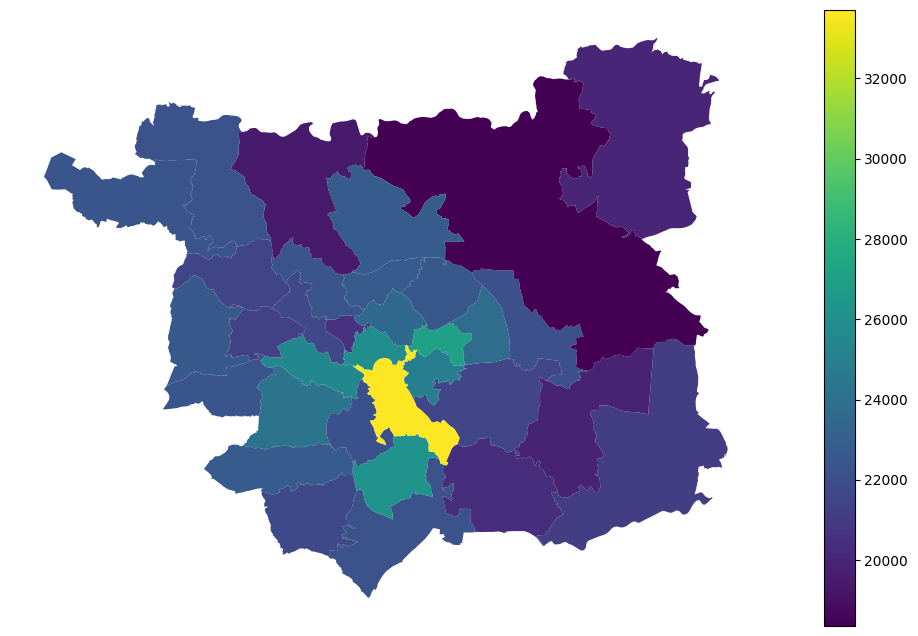

In [173]:
# I created an intial choropleth of population across the wards of Leeds, which will later serve as my base map in the final spatial visualisation.
# Here I created a figure and denote its size.
f,ax = plt.subplots(1, figsize=(16,8))
# Population is chosen, with a legend added.
ward_pop.plot(column='population',legend=True,ax=ax)
# The axis are set to off to assist clarity.
ax.set_axis_off()
plt.show();

In [174]:
# Now to create the additional layers that will sit atop the base map created above.
# This .csv contains data on the recycling points of Leeds
bins = pd.read_csv('Recycling_Points.csv')

In [175]:
# I begun data preprocessing stage by analysing the columns counts and noticed large differences.
bins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Site Name                     376 non-null    object 
 1   Address                       375 non-null    object 
 2   Post Code                     375 non-null    object 
 3   Location Type                 375 non-null    object 
 4   Ward                          375 non-null    object 
 5   Sticker                       239 non-null    object 
 6   Postcode area                 375 non-null    object 
 7   Site Number                   348 non-null    object 
 8   UPRN                          374 non-null    float64
 9   Latitude                      366 non-null    object 
 10  Longitude                     366 non-null    float64
 11  y                             366 non-null    float64
 12  x                             366 non-null    float64
 13  Recyc

In [176]:
# I created a new dataframe within which to save my edits (following good data practice), and dropped columns that will be unnecessary for the work I intend to do.
bins_clean = bins.drop(columns =['Latitude','Longitude','Address','Location Type', 'UPRN', 'Site Number', 'Postcode area', 'Sticker', 'Non LCC Banks', 'Tally of Sites', 'Cleaning', 'No of  Glass Banks', 'Unnamed: 22','Unnamed: 23','Unnamed: 24','Unnamed: 25','Unnamed: 26','Unnamed: 27','Unnamed: 28','Unnamed: 29','Type', 'Recyclables-Mixed Glass', 'Recyclables-Paper', 'Recyclables-Textiles', 'Recyclables Small Electrical'])
# .info is used to check if it worked.
bins_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Site Name  376 non-null    object 
 1   Post Code  375 non-null    object 
 2   Ward       375 non-null    object 
 3   y          366 non-null    float64
 4   x          366 non-null    float64
dtypes: float64(2), object(3)
memory usage: 14.9+ KB


In [177]:
# Then I used .dropna() to remove the rows with null values.
bins_clean.dropna(inplace=True)
# The cleaned dataframe now has no null values, as denoted by .info() below.
bins_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366 entries, 0 to 375
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Site Name  366 non-null    object 
 1   Post Code  366 non-null    object 
 2   Ward       366 non-null    object 
 3   y          366 non-null    float64
 4   x          366 non-null    float64
dtypes: float64(2), object(3)
memory usage: 17.2+ KB


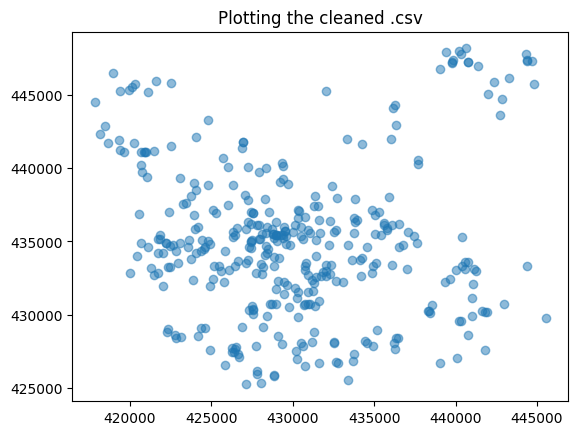

In [178]:
# Here I use the 'x' and 'y' coordinate columns to plot the data with .scatter. Primarily check for anomalies.
plt.scatter(bins_clean['x'], bins_clean['y'], alpha=0.5)
# Adding a title
plt.title('Plotting the cleaned .csv')
plt.show()

In [179]:
ward_pop.crs
# Here I checked the ward_pop layer's crs.
# Given the context of the recycling points, the crs for the .csv is likely to be epgs:27700.
# As they matched, I was able to create a map.


<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [180]:
# I wanted my visualisation to contain a buffer that gives some indication of the accessibility of the bring sites.
# The dataframe had no geometry columnn combining both coordinates into a single field.
# The buffer needs to be created from a single point, so here I created a new dataframe called binscleanpoints, with the added geometry column.
points = bins_clean.apply(lambda row: Point(row.x, row.y), axis=1)
binscleanpoints = gpd.GeoDataFrame(bins_clean, geometry=points)
# With the required column added, I created a new layer that will form the buffer.
bins_buffer = binscleanpoints.copy()
# The buffer centered on the points in the geometry column, and was set to 1000 metres (considered an accessible distance).
# I knew the units would be metres in this instance, because the .crs of the layer is epsg:27700.
bins_buffer['geometry'] = binscleanpoints.buffer(1000)


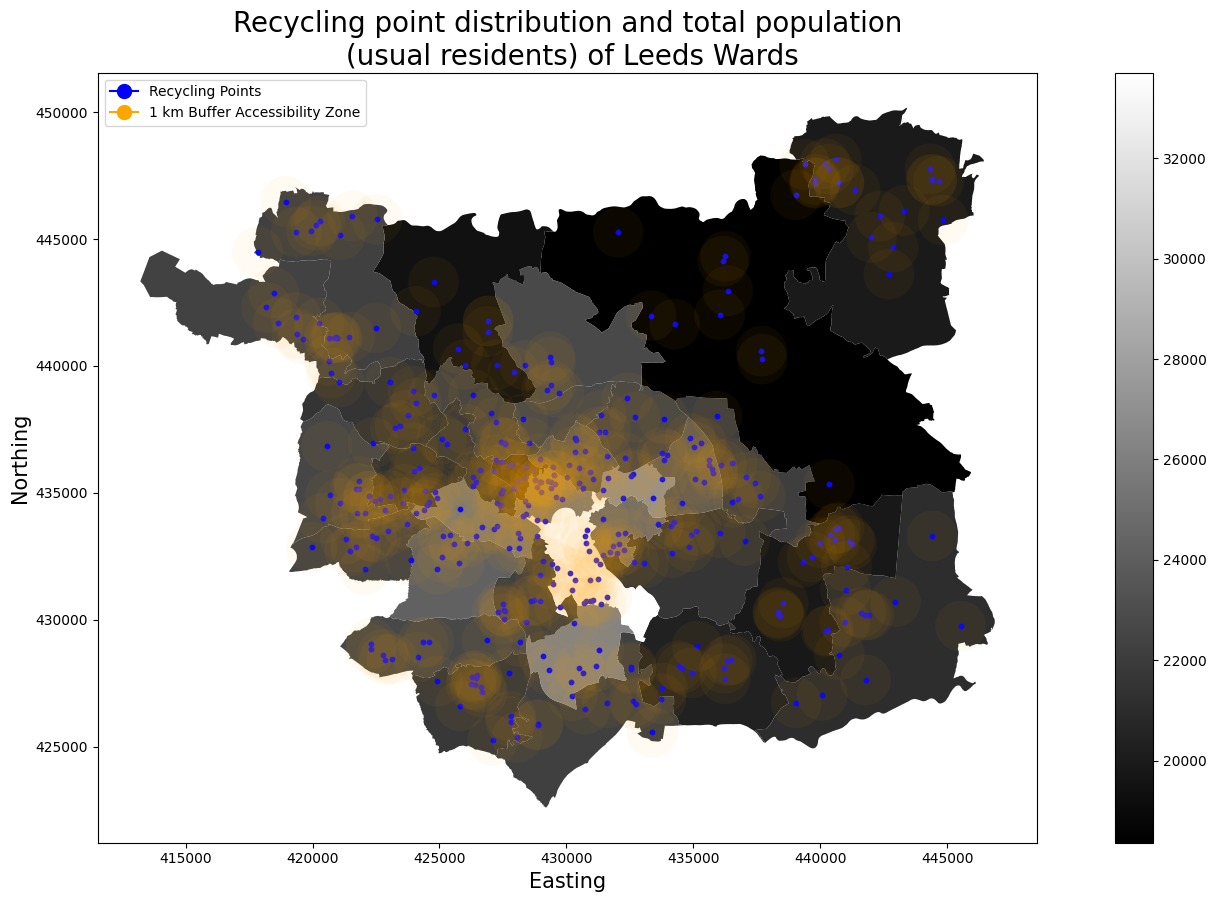

In [181]:
# Data visualisation (Spatial)
# I created a figure and defined its size
f, ax = plt.subplots(1, figsize=(20, 10))

# The base map is the ward_pop layer plotted by the population column. A grey gradient is applied with "cmap".
base = ward_pop.plot(column='population', ax=ax, legend=True, cmap= 'gray')
# The recycling points were plotted with .scatter, using the 'x' and 'y' columns in the .csv, as experimented with earlier.
plt.scatter(bins_clean['x'], bins_clean['y'], color='blue', label='Recycling Points', s=10)
# Axis labels to increase readability were added, and their font size defined.
plt.xlabel('Easting', fontsize=15)
plt.ylabel('Northing', fontsize=15)
# The buffer zone created above was plotted and assigned an alpha value for readability in busier areas.
bins_buffer.plot(ax=ax, color='orange', alpha=0.05)
# A title is added \n is used to move the title onto two lines.
plt.title('Recycling point distribution and total population\n (usual residents) of Leeds Wards', fontsize=20)

# Custom legend markers had to be made manually due to the presence of a buffer zone. Line2D was used to create unique markers for both the recycking points and the buffer.
recycling_markers = Line2D([0], [0], marker='o', color='b', label='Recycling Points', markerfacecolor='b', markersize=10)
buffer_markers = Line2D([0], [0], marker='o', color='orange', label='1 km Buffer Accessibility Zone', markerfacecolor='orange', markersize=10)
# Loc was used to move the legend so that it did not overlap my map.
plt.legend(handles=[recycling_markers, buffer_markers], loc='upper left')

# Producing the plot.
plt.show()






**Spatial Visualisation Choices**

The visualisation produced above compares the distribution of recycling bring sites to the populations of the wards they service. The total population of usual residence is denoted using a choropleth, deemed most appropriate for portraying the geographic variability of this variable across the study area. The bring sites are depicted using a vector point layer projected using the British National Grid (EPSG: 27700) coordinate reference system, most accurate for locations within England. Buffer zones, measuring 1 km, have been applied to these points to represent what has been considered by this study, with reference to literature, an accessible distance to these facilities (Robinson and Read, 2005; Hickford et al, 2009; Roy et al, 2022).

Prior to visualisation, the data underwent preprocessing to enhance its accuracy. The wards of England were clipped by the Leeds boundary, and subsequently joined to the census data using the common field of ward names. Null values were dropped and the column of interest renamed. The brings data required the addition of a geometry column derived by combining the x and y coordinates into a single point for a buffer to be added.

The colour palette utilised has considered a colour blind audience, relying on a high-contrast greyscale to denote differences in ward population. The points and buffer zones are set to blue and orange respectively, as these two colours are generally distinguishable for most colour blindness varieties (Enchroma, 2024). The axis are labelled northing and easting to increase readability and enable sites to be accurately located. An appropriate title was added and the legend was moved to the upper left so as not to obscure the map. The handles were manually created because the default legend did not display the buffer.

The intended audience and usage of a visualisation of this kind is multifaceted. Primarily, it has been designed for Leeds City Council to analyse whether the number of recycling bring sites currently situated in each ward is commensurate to the amount of people they serve. Few sites in a highly populated area could suggest that current infrastructure is overburdened and prompt a re-evaluation of the quantity of sites required. The addition of buffer zones represents a measure of accessibility indicating the level of coverage these facilities provide. Their alpha value assists readability, and through its brightness conveys where sites’ ranges overlap, potentially depicting an inefficient distribution. Though not wholly appropriate in this form, the addition of labels or roads to the map could enable it to be used by people to find their closest deposit site. This visualisation could result in better, and more adequately distributed recycling facilities, which is a cause for public good given the importance of minimising waste on the environment (Lamma, 2021, p.301).




**Non-Spatial Visualisation**

The second visualisation further analyses public access to recycling. It explores whether a correlation exists between the population of a ward and the number of sites contained within it. Additional data preprocessing was required to join dataframes and amend errors present within them. The resultant scatter plot provides a statistical context to the map made previously.


In [182]:
# For this visualisation I need to join the data I have on ward populations and recycling bins
# So some more data processing is required to make this possible.
# Hopefully creating a dataframe that denotes all of the recycling brings per ward.
# Here I count the number of brings associated with each ward
brings = bins_clean['Ward'].value_counts()
# I add them to a new df called brings_df
brings_df = brings.reset_index()
# I change the column headings to make it more readble.
brings_df.columns = ['ward', 'brings']
print(brings_df)
# The number of brings per ward are shown below
# I noticed there are 38 entries, but there should only be 33 wards, so I set about fixing the issue.


                             ward  brings
0                        Wetherby      19
1               Beeston & Holbeck      17
2        Garforth and Swillington      16
3                 Chapel Allerton      16
4                          Armley      15
5                Otley and Yeadon      15
6                City and Hunslet      15
7                      Headingley      15
8                          Pudsey      13
9              Kippax and Methley      13
10                   Morley South      12
11                       Harewood      12
12        Hyde Park and Woodhouse      12
13            Adel and Wharfedale      11
14         Ardsley and Robin Hood      11
15          Calverley and Farsley      11
16        Bramley and Stanningley      11
17                       Rothwell      11
18                      Kirkstall      11
19                   Morley North      10
20  Burmantofts and Richmond Hill      10
21       Killingbeck and Seacroft       9
22                      Horsforth 

In [183]:
# I use my cleaned 'ward_pop' dataframe from the previous visualisation as a reference for the wards that I'll use to make the data join.

print(ward_pop['ward'])

2            Ardsley and Robin Hood
3                          Rothwell
4                    Middleton Park
7                      Morley South
9                      Morley North
11              Farnley and Wortley
12                           Pudsey
14                           Armley
15                       Headingley
16          Bramley and Stanningley
17            Calverley and Farsley
19                        Kirkstall
20              Beeston and Holbeck
21                    Temple Newsam
22                 City and Hunslet
23    Burmantofts and Richmond Hill
24          Hyde Park and Woodhouse
25             Gipton and Harehills
26         Killingbeck and Seacroft
27                  Chapel Allerton
28                         Roundhay
29                         Moortown
32               Kippax and Methley
33         Garforth and Swillington
34         Cross Gates and Whinmoor
35                         Harewood
36                         Wetherby
38                        Al

In [184]:
# The additional entries in the brings dataset are districts, each of which belong to a different ward
# So I change the total number of brings in each respective ward to consider the total of these districts.
brings_df.loc[brings_df['ward'] == 'Hyde Park and Woodhouse', 'brings'] = '14'
brings_df.loc[brings_df['ward'] == 'City and Hunslet', 'brings'] = '17'
brings_df.loc[brings_df['ward'] == 'Temple Newsam', 'brings'] = '9'
brings_df.loc[brings_df['ward'] == 'Kirkstall', 'brings'] = '12'
brings_df.loc[brings_df['ward'] == 'Moortown', 'brings'] = '4'
# This ward name was spelt different, and would've caused an error when joining, so I replaced that also.
brings_df.loc[brings_df['ward'] == 'Beeston & Holbeck', 'ward'] = 'Beeston and Holbeck'
#I print to see my changes.
print(brings_df)

                             ward brings
0                        Wetherby     19
1             Beeston and Holbeck     17
2        Garforth and Swillington     16
3                 Chapel Allerton     16
4                          Armley     15
5                Otley and Yeadon     15
6                City and Hunslet     17
7                      Headingley     15
8                          Pudsey     13
9              Kippax and Methley     13
10                   Morley South     12
11                       Harewood     12
12        Hyde Park and Woodhouse     14
13            Adel and Wharfedale     11
14         Ardsley and Robin Hood     11
15          Calverley and Farsley     11
16        Bramley and Stanningley     11
17                       Rothwell     11
18                      Kirkstall     12
19                   Morley North     10
20  Burmantofts and Richmond Hill     10
21       Killingbeck and Seacroft      9
22                      Horsforth      8
23            Gu

In [185]:
# Then I dropped the now unecessary districts.
brings_df = brings_df.drop(brings_df[brings_df.ward == 'Woodhouse'].index)
brings_df = brings_df.drop(brings_df[brings_df.ward == 'City Centre'].index)
brings_df = brings_df.drop(brings_df[brings_df.ward == 'Halton'].index)
brings_df = brings_df.drop(brings_df[brings_df.ward == 'Burley'].index)
brings_df = brings_df.drop(brings_df[brings_df.ward == 'Meanwood'].index)
# Print results to ensure it has all worked.
print(brings_df)
# I now have the 33 wards requried on both dataframes.

                             ward brings
0                        Wetherby     19
1             Beeston and Holbeck     17
2        Garforth and Swillington     16
3                 Chapel Allerton     16
4                          Armley     15
5                Otley and Yeadon     15
6                City and Hunslet     17
7                      Headingley     15
8                          Pudsey     13
9              Kippax and Methley     13
10                   Morley South     12
11                       Harewood     12
12        Hyde Park and Woodhouse     14
13            Adel and Wharfedale     11
14         Ardsley and Robin Hood     11
15          Calverley and Farsley     11
16        Bramley and Stanningley     11
17                       Rothwell     11
18                      Kirkstall     12
19                   Morley North     10
20  Burmantofts and Richmond Hill     10
21       Killingbeck and Seacroft      9
22                      Horsforth      8
23            Gu

In [186]:
# I created a join between the two dataframes, so that the ward populations and the number of recycling brings are in one place.
brings_pop  = pd.merge(brings_df, ward_pop,  left_on='ward', right_on='ward', how='left')


In [187]:
#I tidied the dataframe by removing some unncessary columns.
brings_pop.drop(columns =['name', 'label', 'geometry', 'Id','code_y', 'code_x','type','Population (usual residents) : Density (number of persons per Hectare) - Unit : Persons','Population (usual residents) : All households - Unit : Households','Population (usual residents) : All usual residents in households - Unit : Persons' ], inplace=True)


In [188]:
brings_pop.head()

ward brings  population
0                  Wetherby     19     19979.0
1       Beeston and Holbeck     17     22187.0
2  Garforth and Swillington     16     19811.0
3           Chapel Allerton     16     23536.0
4                    Armley     15     25550.0

In [189]:
# Before creating my visualisation I encountered an error that said datatypes were not able to be plotted. So I changed the 'brings' column was numeric and it fixed the issue.
brings_pop['brings'] = pd.to_numeric(brings_df['brings'])

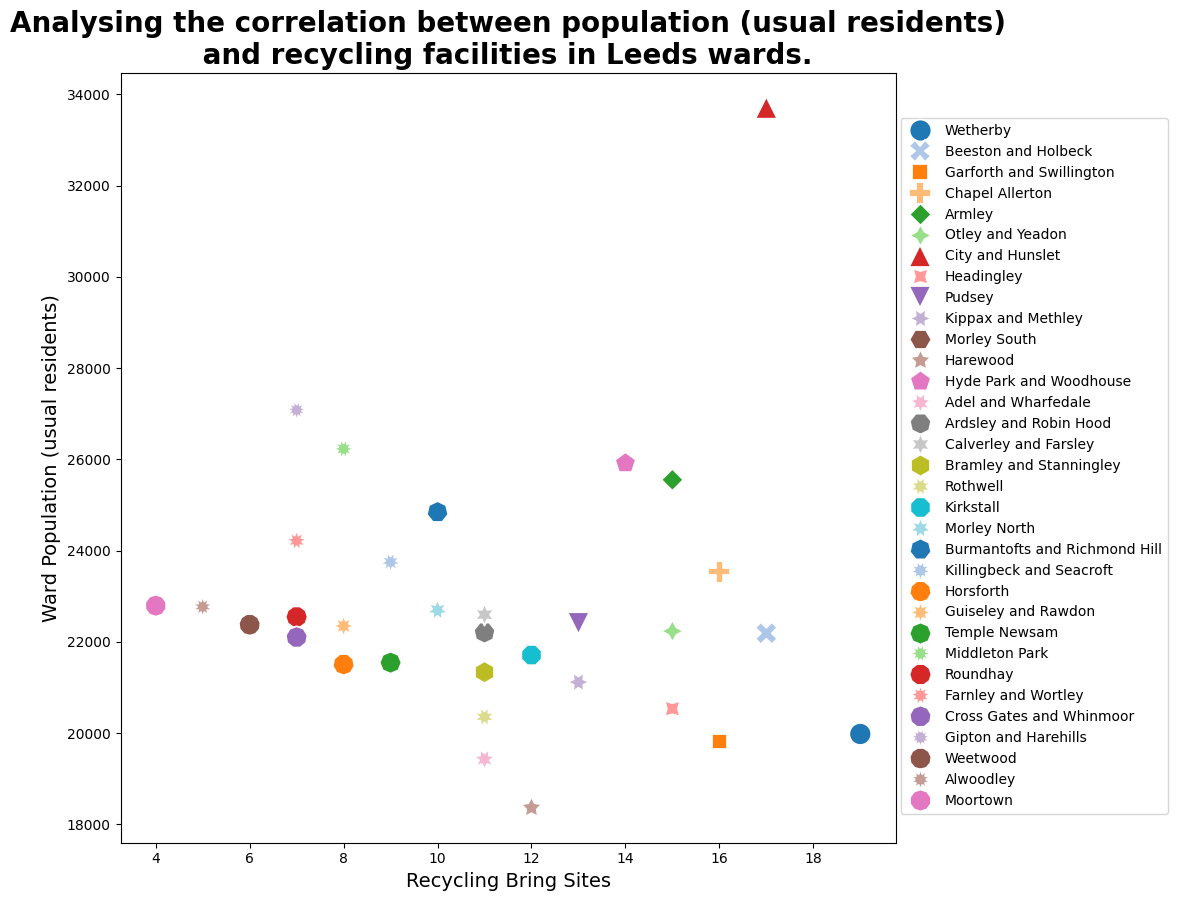

In [190]:
# Creating a suitability sized figure for my visualisation
plt.figure(figsize=(10,10))
# I used the seaborn package to create the scatter plot.
# A scatter plot was chosen because it would enable a correlation between the variables to be percieved.

# Due to the number of unique points I wanted to display, I needed to create a custom colour palette to make them more distinct from one another.
# I used seaborn and create a new palette with the tab20 range of colours. I defined the length to the size of the wards column, and used .unique so each colour is different.
ward_palette = sns.color_palette("tab20", len(brings_pop['ward'].unique()))


# Here I defined each axis vairbale and the size of markers. I added an alpha to make overlapping points easier to see, and added a style so the wards are different shapes.
sns.scatterplot(data=brings_pop, x='brings', y='population', hue='ward', palette=ward_palette, s=250, style='ward')

# I styled the map with the parameters below, adding a title and making it bold. \n is used to break the title into two lines.
plt.title ('Analysing the correlation between population (usual residents)\n and recycling facilities in Leeds wards. ', fontsize=20, fontweight='bold')
# Chosing appropriate axis titles.
plt.xlabel('Recycling Bring Sites', fontsize=14)
plt.ylabel('Ward Population (usual residents)', fontsize=14)
# I needed to reposition the legend so it did obfuscate any of the data.
plt.legend(loc='upper right', bbox_to_anchor=(1.36, 0.95))
# Loading the visualisation.
plt.show()


**Non-spatial Visualisation Choices**

The non-spatial visualisation is a scatter plot comparing the total population of Leeds wards to their recycling bring sites. These numeric variables are well suited to a graph of this kind and will denote any correlations present. Ward names have been added as an additional categorical variable to identify the data points. This part of the project required the creation of a new DataFrame derived from data contained within those used previously.

The bring sites data set contains an entry for each site detailing its location and associated ward. However much preprocessing was required to make it usable. Value_counts() was employed to determine the frequency with which each ward was mentioned, thus denoting the number of bring sites. The resultant list had to be corrected, for it contained several districts (smaller areas within wards). The district values were added to the ward they belonged to before being removed. Spelling differences had to also be amended before a data join could be used to merge the bring and census frames using the ward names as a common field.

The graph is contained within an adequately sized figure and the axes labelled to increase readability. The “hue” of the 33 wards is displayed with a custom colour palette (tab20) and assigned a shape using the “style” function. This visualisation is less suitable for colour blind audiences due to the number of categorical variables present, however it is hoped the use of shapes will be of some assistance (Lee et al, 2020). The large legend is positioned to the right, moved from its original position where it obfuscated large parts of the graph.

The target audience of this plot is similar to the first, hopefully enabling town planners and local authorities to reconsider the layout of current recycling facilities. Interestingly, there appears to be little correlation between population and bring sites. Wetherby, for instance, has the most despite its low population, by contrast it would appear Gipton and Harehills has surprisingly few. Headingly’s population by far exceeds that of other wards, something that is not reflected by its bring sites. Observations like these, and any other patterns dictating the correlation, will hopefully lead to changes that will benefit public recycling initiatives.


**Conclusion**


Using publicly available datasets, this project has aimed to evaluate the effectiveness of recycling bring sites across Leeds. Total population has been used across both visualisations as a barometer for the demand placed on each wards’ facilities. While the Euclidean buffer zone applied in the spatial visualisation is not perfect, and a network analysis of street access would be more accurate, it still provides some measure of accessibility. The lack of correlation between the variables plotted in the non-spatial visualisation suggests current bring allocation does not reflect public waste levels. However, it may also denote a proclivity towards home recycling and a lower reliance on bring sites. Though, as has been suggested elsewhere (Zhang et al, 2016; Reijonen et al, 2021; Roy et al, 2022), accessibility plays a leading role in people’s attitudes towards recycling, thus site distribution may have great influence over public waste disposal. Future work could analyse whether similar trends are observed across other cities.



**Bibliography**

Data Mill North. 2024. *Bring sites: Leeds City Council*. [Online]. [Accessed 15 May 2024]. Available at: https://datamillnorth.org/dataset/23y63/bring-sites

Enchroma. 2024. *What do Colour Blind People See?* [Online]. [Accessed 16 May 2024].  Available at: https://enchroma.com/blogs/beyond-color/how-color-blind-see

Hickford, A., Cherrett, T. and Maynard, S. 2009. Transport implications of bring-site recycling. *Waste and Resource Management*. **162**(1), pp.29-36.

Kassim, S.M. 2012. The Importance of Recycling in Solid Waste Management. *Macromolecular Symposia*. **320**(1), pp.43-49.

Lamma, O.A. 2021. The impact of recycling in preserving the environment. *International Journal of Applied Research*. **7**(11), pp.297-302.

Lee, H., Lee, E. and Choi, G. 2020. Wayfinding Signage for People with Color Blindness. *Journal of Interior Design*. **45**(2), pp.35-54.

Reijonen, H., Bellman, S., Murphy, J. and Kokkonen, H. 2021. Factors relating to recycling plastic packaging in Finland’s new waste management scheme. *Waste Management*. **131**, pp.88-97.

Robinson, G.M. and Read, A.D. 2005. Recycling behaviour in a London Borough: Results form large-scale household surveys. *Resources, Conservation and Recycling*. **45**(1), pp.70-83.

Roy, D., Berry, E. and Dempster, M. 2022. “If it is not made easy for me, I will just not bother”. A qualitative exploration of the barriers and facilitators to recycling plastics. *PLOS ONE*. **17** (5), article no: e0267284 [no pagination].

Zhang, S., Zhang, M., Yu X. and Ren, H. 2016. What keeps Chinese from recycling: Accessibility of recycling facilities and the behaviour. *Resources, Conservation and Recycling*. **109**, pp.176-186.  

**Datasets**


Data Mill North. 2023. Bring Sites. *Leeds City Council*. [Online]. [Accessed 14 May 2024]. Available from: https://datamillnorth.org/dataset/23y63/bring-sites

Office for National Statistics. 2011.Census Aggregate data. *UK Data Service*. [Accessed 14 May 2024]. Available from: http://dx.doi.org/10.5257/census/aggregate-2011-2


Office for National Statistics. 2011. Leeds Local Authority Boundary. *UK Data Service*. [Accessed 14 May 2024]. Available from: https://ukdataservice.ac.uk/learning-hub/census/other-information/census-boundary-data/


Office for National Statistics. 2011. English Electoral Wards and Divisions. *UK Data Service*. [Accessed 14 May 2024]. Available from: https://ukdataservice.ac.uk/learning-hub/census/other-information/census-boundary-data/